# Model choosing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from datetime import datetime
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)

print("✅ Kütüphaneler yüklendi")


✅ Kütüphaneler yüklendi


In [2]:
# =====================================================
# CELL 2: BALANCED VERİYİ YÜKLE
# =====================================================

DATA_PATH = '../data/processed/multiclass_dataset_balanced.parquet'

print(f"📂 Balanced veri yükleniyor: {DATA_PATH}")

df = pd.read_parquet(DATA_PATH, engine='pyarrow')

print(f"✅ Veri yüklendi!")
print(f"  Shape: {df.shape}")
print(f"  Memory: {df.memory_usage(deep=True).sum() / (1024**2):.0f} MB")

# Class names
CLASS_NAMES = {
    0: 'Benign',
    1: 'DoS/DDoS',
    2: 'Web Attack',
    3: 'Port Scan',
    4: 'Brute Force',
    5: 'Botnet'
}

# Label dağılımı
print(f"\n📊 Label Dağılımı:")
label_counts = df['Label'].value_counts().sort_index()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label} - {CLASS_NAMES[label]}: {count:,} ({percentage:.1f}%)")

📂 Balanced veri yükleniyor: ../data/processed/multiclass_dataset_balanced.parquet
✅ Veri yüklendi!
  Shape: (851801, 122)
  Memory: 1087 MB

📊 Label Dağılımı:
  0 - Benign: 200,000 (23.5%)
  1 - DoS/DDoS: 465,374 (54.6%)
  2 - Web Attack: 4,116 (0.5%)
  3 - Port Scan: 161,323 (18.9%)
  4 - Brute Force: 15,480 (1.8%)
  5 - Botnet: 5,508 (0.6%)


In [3]:
# =====================================================
# CELL 3: FEATURES VE TARGET AYIRMA + OBJECT KOLONLARI ÇIKAR
# =====================================================

print("\n🎯 Features ve Target ayrılıyor...")

# Label'ı ayır
y = df['Label']

# Object kolonları bul
object_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n🗑️  Object kolonlar bulundu: {len(object_cols)}")
for col in object_cols:
    print(f"  - {col} (dtype: {df[col].dtype})")

# Object kolonları çıkar (metadata)
X = df.drop(['Label'] + object_cols, axis=1)

print(f"\n✅ Features hazır!")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Feature sayısı: {X.shape[1]}")
print(f"  Çıkarılan metadata kolonlar: {len(object_cols)}")

# Feature isimleri kaydet
feature_names = X.columns.tolist()
print(f"  Feature isimleri kaydedildi")

# Metadata kolonları kaydet (daha sonra inference'da kullanılacak)
metadata_cols = object_cols
print(f"\n📝 Metadata kolonlar: {metadata_cols}")

# DataFrame'i temizle (RAM)
del df
gc.collect()
print(f"\n🧹 RAM temizlendi")


🎯 Features ve Target ayrılıyor...

🗑️  Object kolonlar bulundu: 5
  - flow_id (dtype: object)
  - timestamp (dtype: object)
  - src_ip (dtype: object)
  - dst_ip (dtype: object)
  - protocol (dtype: object)

✅ Features hazır!
  X shape: (851801, 116)
  y shape: (851801,)
  Feature sayısı: 116
  Çıkarılan metadata kolonlar: 5
  Feature isimleri kaydedildi

📝 Metadata kolonlar: ['flow_id', 'timestamp', 'src_ip', 'dst_ip', 'protocol']

🧹 RAM temizlendi


In [4]:
# =====================================================
# CELL 4: TRAIN/TEST SPLIT
# =====================================================

print("\n✂️  Train/Test split yapılıyor...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # %80 train, %20 test
    random_state=42,
    stratify=y            # ✅ Her sınıftan dengeli al
)

print(f"✅ Split tamamlandı!")
print(f"  Train set: {X_train.shape[0]:,} satır ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:  {X_test.shape[0]:,} satır ({X_test.shape[0]/len(X)*100:.1f}%)")

# Train set label dağılımı
print(f"\n📊 Train Set Label Dağılımı:")
train_label_counts = y_train.value_counts().sort_index()
for label, count in train_label_counts.items():
    print(f"  {CLASS_NAMES[label]}: {count:,}")

# Test set label dağılımı
print(f"\n📊 Test Set Label Dağılımı:")
test_label_counts = y_test.value_counts().sort_index()
for label, count in test_label_counts.items():
    print(f"  {CLASS_NAMES[label]}: {count:,}")


✂️  Train/Test split yapılıyor...
✅ Split tamamlandı!
  Train set: 681,440 satır (80.0%)
  Test set:  170,361 satır (20.0%)

📊 Train Set Label Dağılımı:
  Benign: 160,000
  DoS/DDoS: 372,299
  Web Attack: 3,293
  Port Scan: 129,058
  Brute Force: 12,384
  Botnet: 4,406

📊 Test Set Label Dağılımı:
  Benign: 40,000
  DoS/DDoS: 93,075
  Web Attack: 823
  Port Scan: 32,265
  Brute Force: 3,096
  Botnet: 1,102


In [5]:
# =====================================================
# CELL 5: FEATURE SCALING
# =====================================================

print("\n⚖️  Feature scaling yapılıyor...")

# StandardScaler oluştur
scaler = StandardScaler()

# Train set'e fit et
X_train_scaled = scaler.fit_transform(X_train)

# Test set'e transform uygula
X_test_scaled = scaler.transform(X_test)

print(f"✅ Scaling tamamlandı!")
print(f"  Train scaled shape: {X_train_scaled.shape}")
print(f"  Test scaled shape: {X_test_scaled.shape}")

# Scaler'ı kaydet (daha sonra inference için gerekli)
scaler_path = '../data/models/scaler.joblib'

joblib.dump(scaler, scaler_path)
print(f"  💾 Scaler kaydedildi: {scaler_path}")


⚖️  Feature scaling yapılıyor...
✅ Scaling tamamlandı!
  Train scaled shape: (681440, 116)
  Test scaled shape: (170361, 116)
  💾 Scaler kaydedildi: ../data/models/scaler.joblib


In [6]:
# =====================================================
# CELL 6: RANDOM FOREST MODEL EĞİTİMİ
# =====================================================

print("\n🤖 Random Forest model eğitimi başlıyor...")
print(f"  ⏱️  Bu işlem 5-15 dakika sürebilir...")

# Model oluştur
model = RandomForestClassifier(
    n_estimators=100,           # 100 ağaç
    max_depth=20,               # Max derinlik
    min_samples_split=10,       # Node split için min örnek
    min_samples_leaf=5,         # Leaf'te min örnek
    class_weight='balanced',    # ✅ Class imbalance için
    random_state=42,
    n_jobs=-1,                  # Tüm CPU'ları kullan
    verbose=1                   # İlerlemeyi göster
)

# Eğit
model.fit(X_train_scaled, y_train)

print(f"\n✅ Model eğitimi tamamlandı!")


🤖 Random Forest model eğitimi başlıyor...
  ⏱️  Bu işlem 5-15 dakika sürebilir...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.6s



✅ Model eğitimi tamamlandı!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished


In [7]:
# =====================================================
# CELL 7: MODEL DEĞERLENDİRME (TEST SET)
# =====================================================

print("\n📊 Model test set'te değerlendiriliyor...")

# Test set üzerinde tahmin
y_pred = model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification Report
print(f"\n📋 Classification Report:")
print("="*70)
print(classification_report(
    y_test, 
    y_pred,
    target_names=[CLASS_NAMES[i] for i in range(6)],
    digits=4
))

# Weighted metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

print(f"\n📈 Weighted Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")


📊 Model test set'te değerlendiriliyor...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



✅ Test Accuracy: 0.9983 (99.83%)

📋 Classification Report:
              precision    recall  f1-score   support

      Benign     0.9991    0.9938    0.9965     40000
    DoS/DDoS     0.9998    0.9998    0.9998     93075
  Web Attack     0.7924    0.9878    0.8794       823
   Port Scan     1.0000    0.9998    0.9999     32265
 Brute Force     0.9990    1.0000    0.9995      3096
      Botnet     0.9875    1.0000    0.9937      1102

    accuracy                         0.9983    170361
   macro avg     0.9630    0.9969    0.9781    170361
weighted avg     0.9986    0.9983    0.9984    170361


📈 Weighted Metrics:
  Precision: 0.9986
  Recall:    0.9983
  F1-Score:  0.9984


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


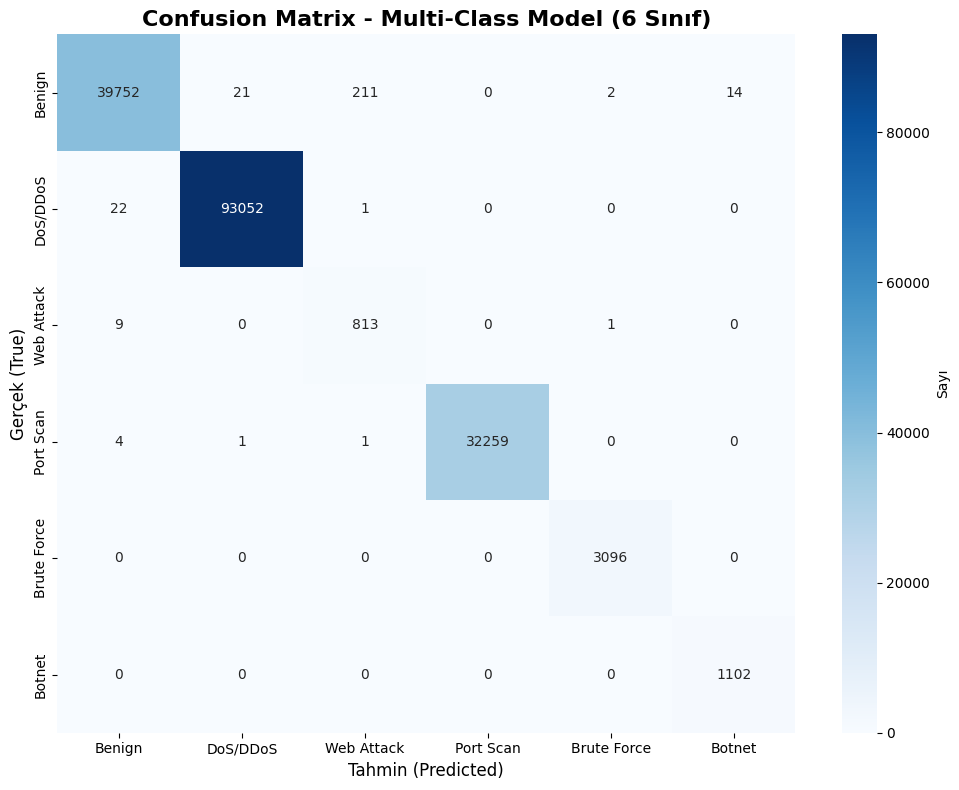

✅ Confusion matrix kaydedildi

📊 Sınıf Bazında Accuracy:
  Benign: 99.38%
  DoS/DDoS: 99.98%
  Web Attack: 98.78%
  Port Scan: 99.98%
  Brute Force: 100.00%
  Botnet: 100.00%


In [9]:
# =====================================================
# CELL 8: CONFUSION MATRIX
# =====================================================

# Confusion matrix hesapla
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[CLASS_NAMES[i] for i in range(6)],
    yticklabels=[CLASS_NAMES[i] for i in range(6)],
    cbar_kws={'label': 'Sayı'}
)
plt.title('Confusion Matrix - Multi-Class Model (6 Sınıf)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Gerçek (True)', fontsize=12)
plt.xlabel('Tahmin (Predicted)', fontsize=12)
plt.tight_layout()
plt.savefig('../data/models/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix kaydedildi")

# Per-class accuracy
print(f"\n📊 Sınıf Bazında Accuracy:")
for i in range(6):
    class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    print(f"  {CLASS_NAMES[i]}: {class_acc:.2%}")

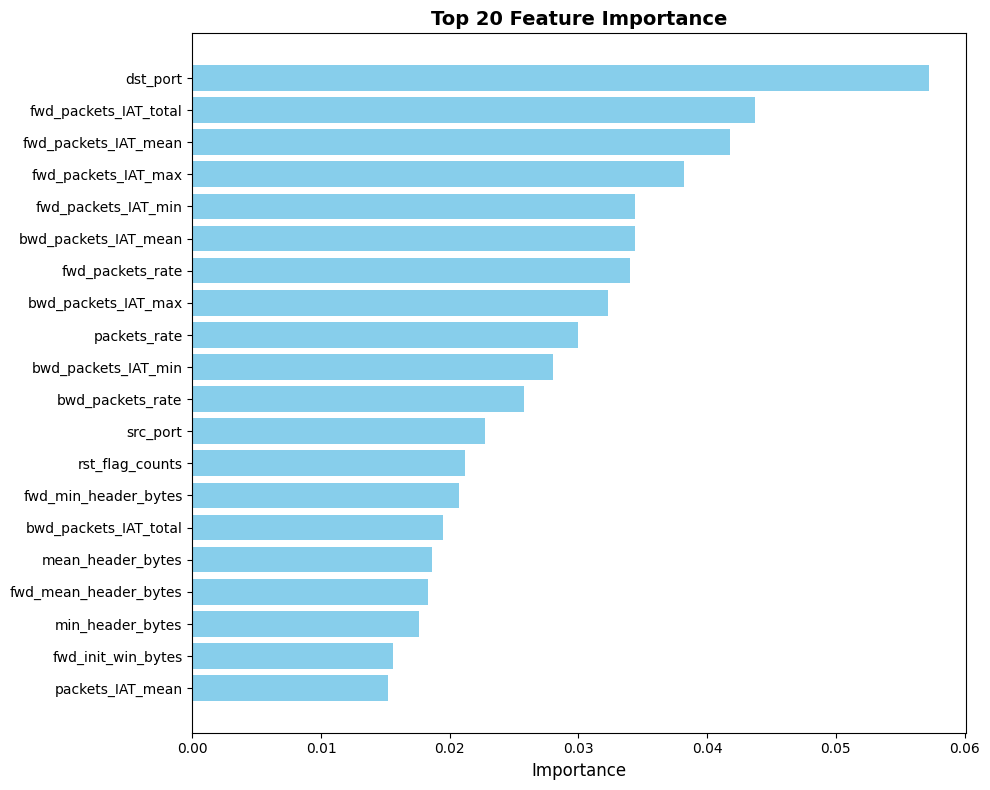

✅ Feature importance grafiği kaydedildi

En önemli 5 feature:
  dst_port: 0.0572
  fwd_packets_IAT_total: 0.0437
  fwd_packets_IAT_mean: 0.0418
  fwd_packets_IAT_max: 0.0382
  fwd_packets_IAT_min: 0.0344


In [10]:
# =====================================================
# CELL 9: FEATURE IMPORTANCE (TOP 20)
# =====================================================

# Feature importance al
importances = model.feature_importances_

# DataFrame'e çevir
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Top 20
top20 = feature_importance_df.head(20)

# Görselleştir
plt.figure(figsize=(10, 8))
plt.barh(range(20), top20['importance'].values[::-1], color='skyblue')
plt.yticks(range(20), top20['feature'].values[::-1])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/models/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Feature importance grafiği kaydedildi")
print(f"\nEn önemli 5 feature:")
for i, row in top20.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

In [11]:
print("\n🔍 Overfitting Kontrolü...")

# Train set accuracy
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"\n📊 Train vs Test:")
print(f"  Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Test Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Fark: {abs(train_accuracy - accuracy):.4f}")

if train_accuracy > 0.999 and accuracy > 0.995:
    print(f"\n⚠️  Her ikisi de çok yüksek!")
    print(f"  Muhtemel sebep: Data leakage veya çok kolay problem")
elif train_accuracy - accuracy > 0.05:
    print(f"\n⚠️  Overfitting olabilir!")
else:
    print(f"\n✅ Model sağlıklı görünüyor")


🔍 Overfitting Kontrolü...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s



📊 Train vs Test:
  Train Accuracy: 0.9985 (99.85%)
  Test Accuracy:  0.9983 (99.83%)
  Fark: 0.0002

✅ Model sağlıklı görünüyor


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.2s finished


# FEATURE SELECTION AND SAVING MODEL

In [14]:
# =====================================================
# CELL 9.5: FEATURE SELECTION (TOP N)
# =====================================================

print("\n🔍 Feature Selection yapılıyor...")

# Kaç feature seçeceğiz?
N_FEATURES = 30  # İstersen 15, 20, 25 yapabilirsin

# En önemli N feature'ı seç
top_features = feature_importance_df.head(N_FEATURES)['feature'].tolist()

print(f"\n✅ Top {N_FEATURES} Feature Seçildi:")
for i, feature in enumerate(top_features, 1):
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    print(f"  {i}. {feature}: {importance:.4f}")

# Toplam importance (DÜZELTİLDİ)
total_importance = feature_importance_df['importance'].sum()  # ✅ Düzeltildi
selected_importance = feature_importance_df.head(N_FEATURES)['importance'].sum()
coverage = (selected_importance / total_importance) * 100

print(f"\n📊 Feature Importance Coverage:")
print(f"  Top {N_FEATURES} feature toplam importance: {selected_importance:.4f}")
print(f"  Tüm feature'ların importance'ı: {total_importance:.4f}")
print(f"  Coverage: {coverage:.2f}%")


🔍 Feature Selection yapılıyor...

✅ Top 30 Feature Seçildi:
  1. dst_port: 0.0572
  2. fwd_packets_IAT_total: 0.0437
  3. fwd_packets_IAT_mean: 0.0418
  4. fwd_packets_IAT_max: 0.0382
  5. fwd_packets_IAT_min: 0.0344
  6. bwd_packets_IAT_mean: 0.0344
  7. fwd_packets_rate: 0.0340
  8. bwd_packets_IAT_max: 0.0323
  9. packets_rate: 0.0300
  10. bwd_packets_IAT_min: 0.0280
  11. bwd_packets_rate: 0.0258
  12. src_port: 0.0228
  13. rst_flag_counts: 0.0212
  14. fwd_min_header_bytes: 0.0207
  15. bwd_packets_IAT_total: 0.0195
  16. mean_header_bytes: 0.0187
  17. fwd_mean_header_bytes: 0.0183
  18. min_header_bytes: 0.0176
  19. fwd_init_win_bytes: 0.0156
  20. packets_IAT_mean: 0.0152
  21. packet_IAT_min: 0.0149
  22. duration: 0.0146
  23. bwd_avg_segment_size: 0.0144
  24. payload_bytes_variance: 0.0140
  25. bwd_payload_bytes_variance: 0.0136
  26. fwd_payload_bytes_std: 0.0134
  27. packet_IAT_total: 0.0132
  28. bwd_payload_bytes_mean: 0.0130
  29. payload_bytes_max: 0.0126
  30. 

In [15]:
# =====================================================
# CELL 9.6: YENİ DATASET (SADECE TOP FEATURES)
# =====================================================

print(f"\n🔄 Yeni dataset oluşturuluyor (sadece top {N_FEATURES} feature)...")

# Train/Test split'i tekrar yap (top features ile)
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print(f"✅ Yeni dataset hazır!")
print(f"  Eski feature sayısı: {X_train.shape[1]}")
print(f"  Yeni feature sayısı: {X_train_selected.shape[1]}")
print(f"  Azalma: %{((X_train.shape[1] - N_FEATURES) / X_train.shape[1] * 100):.1f}")


🔄 Yeni dataset oluşturuluyor (sadece top 30 feature)...
✅ Yeni dataset hazır!
  Eski feature sayısı: 116
  Yeni feature sayısı: 30
  Azalma: %74.1


In [16]:
# =====================================================
# CELL 9.7: YENİ SCALER (TOP FEATURES İÇİN)
# =====================================================

print(f"\n⚖️  Yeni scaler oluşturuluyor (top {N_FEATURES} feature için)...")

# Yeni scaler
scaler_selected = StandardScaler()

# Train set'e fit et
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)

# Test set'e transform uygula
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

print(f"✅ Scaling tamamlandı!")
print(f"  Train shape: {X_train_selected_scaled.shape}")
print(f"  Test shape: {X_test_selected_scaled.shape}")


⚖️  Yeni scaler oluşturuluyor (top 30 feature için)...
✅ Scaling tamamlandı!
  Train shape: (681440, 30)
  Test shape: (170361, 30)


In [17]:
# =====================================================
# CELL 9.8: YENİ MODEL EĞİTİMİ (TOP FEATURES)
# =====================================================

print(f"\n🤖 Yeni model eğitimi başlıyor (sadece top {N_FEATURES} feature)...")
print(f"  ⏱️  Bu işlem 3-10 dakika sürebilir...")

# Yeni model
model_selected = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Eğit
model_selected.fit(X_train_selected_scaled, y_train)

print(f"\n✅ Yeni model eğitimi tamamlandı!")


🤖 Yeni model eğitimi başlıyor (sadece top 30 feature)...
  ⏱️  Bu işlem 3-10 dakika sürebilir...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s



✅ Yeni model eğitimi tamamlandı!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.5s finished



📊 Yeni model test set'te değerlendiriliyor...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished



📈 KARŞILAŞTIRMA:
Metrik               Tüm Features    Top {N_FEATURES} Features Fark      
------------------------------------------------------------
Accuracy             0.9983          0.9983          -0.0001
Precision            0.9986          0.9985          -0.0001
Recall               0.9983          0.9983          -0.0001
F1-Score             0.9984          0.9983          -0.0001

📋 Classification Report (Top 30 Features):
              precision    recall  f1-score   support

      Benign     0.9985    0.9943    0.9964     40000
    DoS/DDoS     0.9997    0.9995    0.9996     93075
  Web Attack     0.7953    0.9866    0.8807       823
   Port Scan     1.0000    0.9997    0.9998     32265
 Brute Force     0.9994    1.0000    0.9997      3096
      Botnet     1.0000    1.0000    1.0000      1102

    accuracy                         0.9983    170361
   macro avg     0.9655    0.9967    0.9794    170361
weighted avg     0.9985    0.9983    0.9983    170361



FileNotFoundError: [Errno 2] No such file or directory: '../models/multiclass_v1/confusion_matrix_comparison.png'

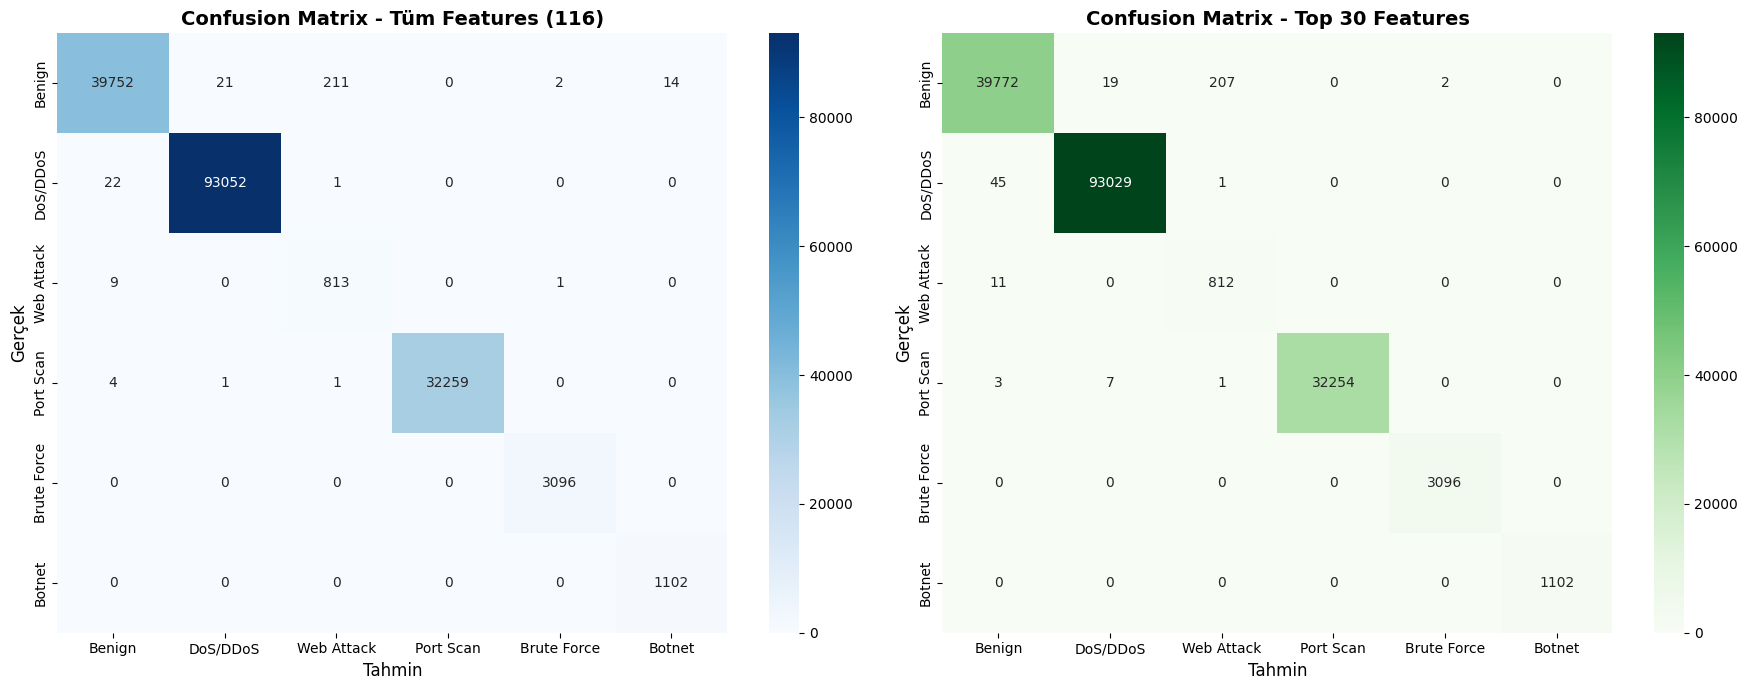

In [18]:
# =====================================================
# CELL 9.9: YENİ MODEL DEĞERLENDİRME
# =====================================================

print("\n📊 Yeni model test set'te değerlendiriliyor...")

# Test set üzerinde tahmin
y_pred_selected = model_selected.predict(X_test_selected_scaled)

# Accuracy
accuracy_selected = accuracy_score(y_test, y_pred_selected)

# Metrics
precision_selected, recall_selected, f1_selected, _ = precision_recall_fscore_support(
    y_test, y_pred_selected, average='weighted'
)

print(f"\n📈 KARŞILAŞTIRMA:")
print(f"{'Metrik':<20} {'Tüm Features':<15} {'Top {N_FEATURES} Features':<15} {'Fark':<10}")
print(f"{'-'*60}")
print(f"{'Accuracy':<20} {accuracy:.4f}          {accuracy_selected:.4f}          {accuracy_selected - accuracy:+.4f}")
print(f"{'Precision':<20} {precision:.4f}          {precision_selected:.4f}          {precision_selected - precision:+.4f}")
print(f"{'Recall':<20} {recall:.4f}          {recall_selected:.4f}          {recall_selected - recall:+.4f}")
print(f"{'F1-Score':<20} {f1:.4f}          {f1_selected:.4f}          {f1_selected - f1:+.4f}")

# Classification Report
print(f"\n📋 Classification Report (Top {N_FEATURES} Features):")
print("="*70)
print(classification_report(
    y_test, 
    y_pred_selected,
    target_names=[CLASS_NAMES[i] for i in range(6)],
    digits=4
))

# Confusion Matrix
cm_selected = confusion_matrix(y_test, y_pred_selected)

# Görselleştir
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Tüm features
sns.heatmap(
    cm, 
    annot=True, fmt='d', cmap='Blues',
    xticklabels=[CLASS_NAMES[i] for i in range(6)],
    yticklabels=[CLASS_NAMES[i] for i in range(6)],
    ax=axes[0]
)
axes[0].set_title(f'Confusion Matrix - Tüm Features ({X_train.shape[1]})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Gerçek', fontsize=12)
axes[0].set_xlabel('Tahmin', fontsize=12)

# Top features
sns.heatmap(
    cm_selected, 
    annot=True, fmt='d', cmap='Greens',
    xticklabels=[CLASS_NAMES[i] for i in range(6)],
    yticklabels=[CLASS_NAMES[i] for i in range(6)],
    ax=axes[1]
)
axes[1].set_title(f'Confusion Matrix - Top {N_FEATURES} Features', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Gerçek', fontsize=12)
axes[1].set_xlabel('Tahmin', fontsize=12)

plt.tight_layout()
plt.savefig('../models/multiclass_v1/confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Karşılaştırma grafiği kaydedildi")

In [21]:
# =====================================================
# CELL 10: YENİ MODEL'İ KAYDET (TOP FEATURES)
# =====================================================

print(f"\n💾 Yeni model kaydediliyor (top {N_FEATURES} features)...")
all_features = feature_names
import os
os.makedirs('../data/models/multiclass_v1', exist_ok=True)

# Model kaydet
model_path = '../data/models/multiclass_v1/model.joblib'
joblib.dump(model_selected, model_path)
print(f"  ✅ Model kaydedildi: {model_path}")

# Scaler kaydet
scaler_path = '../data/models/multiclass_v1/scaler.joblib'
joblib.dump(scaler_selected, scaler_path)
print(f"  ✅ Scaler kaydedildi: {scaler_path}")

# Top feature names kaydet
feature_path = '../data/models/multiclass_v1/feature_names.json'
with open(feature_path, 'w') as f:
    json.dump(top_features, f, indent=2)
print(f"  ✅ Feature names kaydedildi: {feature_path} ({N_FEATURES} features)")

# Metadata columns kaydet
metadata_cols_path = '../data/models/multiclass_v1/metadata_columns.json'
with open(metadata_cols_path, 'w') as f:
    json.dump(metadata_cols, f, indent=2)
print(f"  ✅ Metadata columns kaydedildi: {metadata_cols_path}")

# Model metadata kaydet
metadata = {
    'version': 'v1.0_optimized',
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'RandomForestClassifier',
    'optimization': f'Feature Selection (Top {N_FEATURES})',
    'n_estimators': 100,
    'max_depth': 20,
    'n_classes': 6,
    'class_names': CLASS_NAMES,
    'total_samples': len(X_train) + len(X_test),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features_original': len(all_features),
    'n_features_selected': N_FEATURES,
    'feature_reduction': f"{((len(all_features) - N_FEATURES) / len(all_features) * 100):.1f}%",
    'selected_features': top_features,
    'metadata_columns': metadata_cols,
    'test_accuracy_full': float(accuracy),
    'test_accuracy_selected': float(accuracy_selected),
    'accuracy_drop': float(accuracy - accuracy_selected),
    'test_precision': float(precision_selected),
    'test_recall': float(recall_selected),
    'test_f1_score': float(f1_selected),
    'class_weight': 'balanced',
    'balanced_dataset': True,
    'heartbleed_removed': True
}

metadata_path = '../data/models/multiclass_v1/metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  ✅ Model metadata kaydedildi: {metadata_path}")

print(f"\n📁 Kaydedilen Dosyalar:")
print(f"  1. model.joblib (Top {N_FEATURES} features)")
print(f"  2. scaler.joblib (Top {N_FEATURES} features)")
print(f"  3. feature_names.json ({N_FEATURES} features)")
print(f"  4. metadata_columns.json")
print(f"  6. metadata.json")


💾 Yeni model kaydediliyor (top 30 features)...
  ✅ Model kaydedildi: ../data/models/multiclass_v1/model.joblib
  ✅ Scaler kaydedildi: ../data/models/multiclass_v1/scaler.joblib
  ✅ Feature names kaydedildi: ../data/models/multiclass_v1/feature_names.json (30 features)
  ✅ Metadata columns kaydedildi: ../data/models/multiclass_v1/metadata_columns.json
  ✅ Model metadata kaydedildi: ../data/models/multiclass_v1/metadata.json

📁 Kaydedilen Dosyalar:
  1. model.joblib (Top 30 features)
  2. scaler.joblib (Top 30 features)
  3. feature_names.json (30 features)
  4. metadata_columns.json
  6. metadata.json


In [22]:
# =====================================================
# CELL 11: ÖZET
# =====================================================

print("\n" + "="*70)
print("🎉 GÖREV 1.2: OPTIMIZED MULTI-CLASS MODEL TAMAMLANDI!")
print("="*70)
print(f"✅ Model: Random Forest (100 trees)")
print(f"✅ Sınıf sayısı: 6 (Heartbleed çıkarıldı)")
print(f"✅ Feature Optimization: {len(all_features)} → {N_FEATURES} features")
print(f"✅ Feature Reduction: %{((len(all_features) - N_FEATURES) / len(all_features) * 100):.1f}")

print(f"\n📊 Model Performance:")
print(f"  Tüm Features ({len(all_features)}):")
print(f"    Accuracy:  {accuracy*100:.2f}%")
print(f"    F1-Score:  {f1:.4f}")
print(f"\n  Top {N_FEATURES} Features:")
print(f"    Accuracy:  {accuracy_selected*100:.2f}%")
print(f"    F1-Score:  {f1_selected:.4f}")
print(f"\n  Accuracy Drop: {(accuracy - accuracy_selected)*100:.2f}%")

print(f"\n⚡ Performance Benefits:")
print(f"  NTFlowLyzer extract time: ~{((len(all_features) - N_FEATURES) / len(all_features) * 100):.0f}% faster")
print(f"  Model prediction time: ~{((len(all_features) - N_FEATURES) / len(all_features) * 100):.0f}% faster")
print(f"  RAM usage: ~{((len(all_features) - N_FEATURES) / len(all_features) * 100):.0f}% less")

print(f"\n🚀 SONRAKİ ADIM: GÖREV 1.3 - Inference Pipeline (Semih İkbal)")
print("="*70)


🎉 GÖREV 1.2: OPTIMIZED MULTI-CLASS MODEL TAMAMLANDI!
✅ Model: Random Forest (100 trees)
✅ Sınıf sayısı: 6 (Heartbleed çıkarıldı)
✅ Feature Optimization: 116 → 30 features
✅ Feature Reduction: %74.1

📊 Model Performance:
  Tüm Features (116):
    Accuracy:  99.83%
    F1-Score:  0.9984

  Top 30 Features:
    Accuracy:  99.83%
    F1-Score:  0.9983

  Accuracy Drop: 0.01%

⚡ Performance Benefits:
  NTFlowLyzer extract time: ~74% faster
  Model prediction time: ~74% faster
  RAM usage: ~74% less

🚀 SONRAKİ ADIM: GÖREV 1.3 - Inference Pipeline (Semih İkbal)
